In [3]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import h5py
# 在tf.keras.applications有很多意见与训练好的优秀模型如：VGG16，VGG19，以及这个测试项目用的Xception(一个1000中图片分类模型)

print('TensorFlow version:{}'.format(tf.__version__))
kears = tf.keras
layers = tf.keras.layers

train_dataset = h5py.File('/Users/zhenwuzhou/.keras/datasets/train_catvnoncat.h5', "r")
trainX = np.array(train_dataset["train_set_x"][:])/255  # shape(209,64,64,3)
trainX = tf.image.resize(trainX,[256,256])
trainY = np.array(train_dataset["train_set_y"][:]) # shape(209,)
trainY = trainY.reshape(trainY.shape[0],1) # reshape为 shape(209,1)
    
test_dataset = h5py.File('/Users/zhenwuzhou/.keras/datasets/test_catvnoncat.h5', "r")
testX = np.array(test_dataset["test_set_x"][:])/255
testX = tf.image.resize(testX,[256,256])
testY = np.array(test_dataset["test_set_y"][:])
testY = testY.reshape(testY.shape[0],1)

# trainX_ds = tf.data.Dataset.format_tensor_slices()

TensorFlow version:2.1.0-dev20191006


In [4]:
trainX.shape

TensorShape([209, 256, 256, 3])

In [5]:
# 用Xception 来初始化conv_base层即为前面的卷积和池化层：
# Xception在验证集Top1准确率：0.790；Top5准确率：0.945
# 该模型值支持channels_last的维度顺序为（高度，宽度，通道）
#模型默认出入尺寸为299*299*3 
# 它必须拥有三个输入通道，且宽高必须不小于71
conv_base = tf.keras.applications.xception.Xception(
    # None代表随机初始化;
    #'imagenet'代表加载ImageNet上预训练的权值(迁移学习的的话就要设置为'imagenet')#文件会下载至于/Users/zhenwuzhou/.keras/models/xxx.h5目录下
    # '/Users/zhenwuzhou/.keras/datasets/xception_weights_tf_dim_ordering_tf_kernels_notop.h5' 这样的方式传入本地的相对权重文件路径
    weights = 'imagenet', 
    include_top = False, # 是否包含顶层的全连接层：如果为True的话输入图片尺寸必须为299*299*3 (训练模型是用这种尺寸的图片训练的)
    input_shape = (256,256,3),#当include_top = False时可以指定输入图片的尺寸：必须拥有三个输入通道，且宽高必须不小于71
    # 当include_top = False时有效-指定了特征提取时的池化方式：
    # None代表不池化，直接输出最后一层卷积层的输出(该输出为一个4D张量)
    # ‘avg’代表全局平均池化（GlobalAveragePooling2D），相当于在最后一层卷积后再加了一层全局的平均池化，输出一个2D张量
    # 'max'代表全局最大池化，其他与上面‘avg’一样
    pooling='avg'
#     path ='/Users/zhenwuzhou/.keras/datasets/xception_weights_tf_dim_ordering_tf_kernels.h5'
    ) 

In [148]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_33[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [6]:
 # 建立model模型
model = kears.Sequential([
    conv_base,
#     layers.Flatten(input_shape=(256,256,3)),
    layers.Dense(512,activation='relu'),
    layers.Dense(1,activation='sigmoid')
])

# 模型参数初始化
optimizer = kears.optimizers.Adam(0.00005)
model.compile(optimizer,loss = 'binary_crossentropy',metrics=['acc'])

In [7]:
#model训练开始
histoy = model.fit(trainX,trainY,batch_size=36,epochs=10,validation_data=(testX,testY))

Train on 209 samples, validate on 50 samples
Epoch 1/10
209/209 [==============================] - 69s 330ms/sample - loss: 0.6457 - acc: 0.6986 - val_loss: 0.4690 - val_acc: 0.9000
Epoch 2/10
209/209 [==============================] - 84s 402ms/sample - loss: 0.3849 - acc: 0.9713 - val_loss: 0.3481 - val_acc: 0.9200
Epoch 3/10
209/209 [==============================] - 75s 361ms/sample - loss: 0.2190 - acc: 0.9856 - val_loss: 0.2309 - val_acc: 0.9400
Epoch 4/10
209/209 [==============================] - 74s 352ms/sample - loss: 0.1228 - acc: 0.9952 - val_loss: 0.1465 - val_acc: 0.9800
Epoch 5/10
209/209 [==============================] - 74s 354ms/sample - loss: 0.0711 - acc: 1.0000 - val_loss: 0.0926 - val_acc: 0.9800
Epoch 6/10
209/209 [==============================] - 73s 348ms/sample - loss: 0.0386 - acc: 1.0000 - val_loss: 0.0607 - val_acc: 0.9800
Epoch 7/10
209/209 [==============================] - 72s 345ms/sample - loss: 0.0216 - acc: 1.0000 - val_loss: 0.0390 - val_acc: 1.0

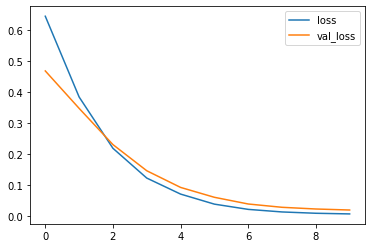

In [8]:
plt.plot(histoy.epoch,histoy.history['loss'],label='loss')
plt.plot(histoy.epoch,histoy.history['val_loss'],label='val_loss')
plt.legend()

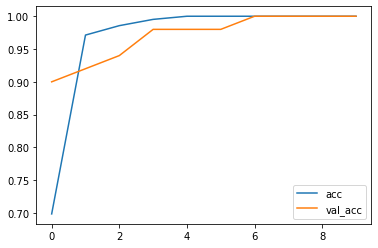

In [9]:
plt.plot(histoy.epoch,histoy.history['acc'],label='acc')
plt.plot(histoy.epoch,histoy.history['val_acc'],label='val_acc')
plt.legend()

In [10]:
model.save_weights('/Users/zhenwuzhou/.keras/models/xception_test_weight.h5')#把数据保存起来